### CS 559 WS Group 3 

Citations: Chatgpt4 for assistance and debugging

### Part 1: Training Data and Preperation

In [7]:
import pandas as pd

# Load the dataset
file_path = 'train_data.csv'
data = pd.read_csv(file_path)
print(data.head())  # Display the first few rows of the dataset to understand its structure


   Index  Bankrupt?   ROA(C) before interest and depreciation before interest  \
0      0          0                                           0.450397          
1      1          0                                           0.530005          
2      2          0                                           0.571150          
3      3          0                                           0.483401          
4      4          0                                           0.510359          

    ROA(A) before interest and % after tax  \
0                                 0.504034   
1                                 0.572885   
2                                 0.620148   
3                                 0.556694   
4                                 0.537287   

    ROA(B) before interest and depreciation after tax  \
0                                           0.506986    
1                                           0.574763    
2                                           0.624177    
3       

##### Analyzing Feature Importance, Feature Engineering and Reduction

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest

# Separate features and the target
X = data.iloc[:, 2:]  # assuming the first two columns are index and target
y = data['Bankrupt?']

# Scale features (important for logistic regression)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using RFE with Logistic Regression
logreg = LogisticRegression()
rfe = RFECV(estimator=logreg, step=1, cv=5, scoring='accuracy')
rfe.fit(X_scaled, y)

# Select features according to the RFE
selected_features_rfe = X.columns[rfe.support_]

# Further selection using Chi-Squared Test
chi2_selector = SelectKBest(chi2, k=min(50, len(selected_features_rfe)))  # Adjust the number of features as needed
X_kbest_features = chi2_selector.fit_transform(X_scaled[:, rfe.support_], y)
selected_features_final = selected_features_rfe[chi2_selector.get_support()]

# Print and save the selected features
print("Selected features:", selected_features_final)
print("Number of final features selected:", len(selected_features_final))

# Save the filtered dataset
selected_indices = [list(X.columns).index(feat) for feat in selected_features_final]
X_filtered = X.iloc[:, selected_indices]
X_filtered['Bankrupt?'] = y  # reattach the target column
X_filtered.to_csv('filtered_train_data.csv', index=False)
print("Filtered data saved successfully.")

Selected features: Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)', ' Debt ratio %',
       ' Net worth/Assets', ' Long-term fund suitability ratio (A)',
       ' Borrowing dependency', ' Operating profit/Paid-in capital',
       ' Net profit before tax/Paid-in capital', ' Total Asset Turnover',
       ' Accounts Receivable Turnover', ' Fixed Assets Turnover Frequency',
       ' Revenue per person', ' Operating profit per person',
       ' Working Capital to Total Assets', ' Quick Assets/Total Assets',
       ' Cash/Total Assets', ' Cash/Current Liability',
       ' Current Liability to Assets', ' Total ex

C:\Users\Waybo\AppData\Local\Temp\ipykernel_27156\445381053.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filtered['Bankrupt?'] = y  # reattach the target column


Filtered data saved successfully.


### Part 2: Clustering

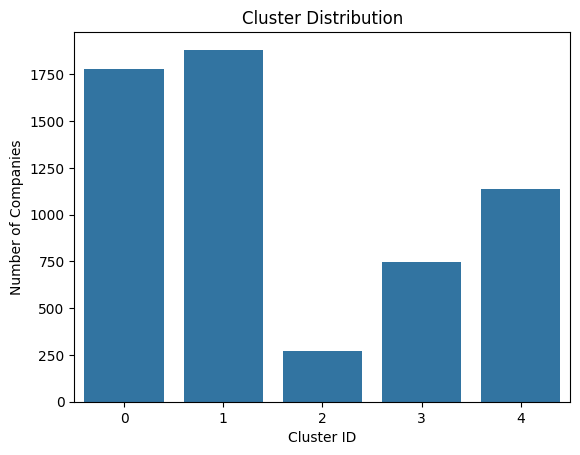

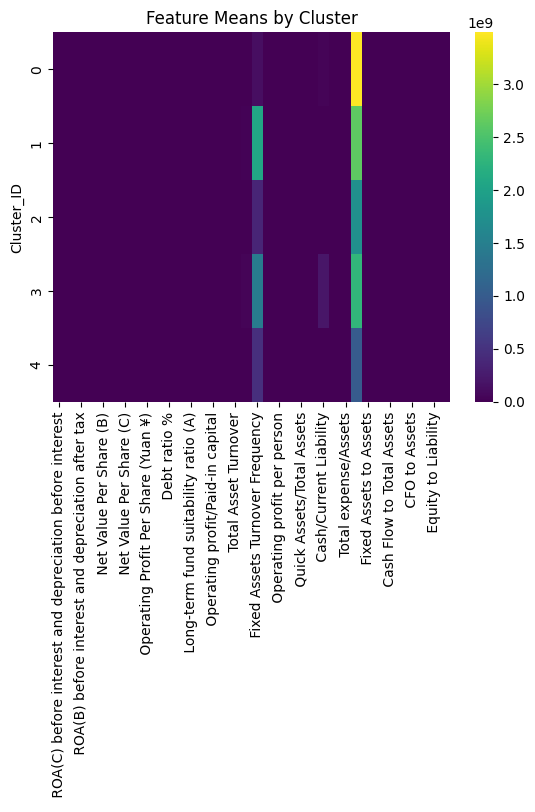

In [9]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "filtered_train_data.csv"  # Update this path
data = pd.read_csv(data_path)

# Drop the target variable for clustering
data_clustering = data.drop(['Bankrupt?'], axis=1)

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clustering)

# Set the number of clusters (at least as many as team members)
k = 5  # Update based on your team size or a different choice

# KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
clusters_kmeans = kmeans.fit_predict(data_scaled)

# Gaussian Mixture
gm = GaussianMixture(n_components=k, random_state=42)
clusters_gm = gm.fit_predict(data_scaled)

# Add cluster ID back to the dataframe for analysis
data['Cluster_ID'] = clusters_kmeans  # or use clusters_gm

# Analyze cluster distribution
sns.countplot(x='Cluster_ID', data=data)
plt.title('Cluster Distribution')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Companies')
plt.show()

# Analyze mean feature values per cluster
cluster_means = data.groupby('Cluster_ID').mean()
sns.heatmap(cluster_means, cmap='viridis')
plt.title('Feature Means by Cluster')
plt.show()

data.to_csv('clustered_data.csv', index=False)


In [10]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the clustered training data
clustered_data = pd.read_csv('clustered_data.csv')
X = clustered_data.drop(['Bankrupt?', 'Cluster_ID'], axis=1)
y = clustered_data['Bankrupt?']
clusters = clustered_data['Cluster_ID']

# Prep Data for Model Training
X_train, X_val, y_train, y_val, clusters_train, clusters_val = train_test_split(
    X, y, clusters, test_size=0.20, random_state=42)


In [12]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression



# Train Meta Model
meta_X_train = pd.DataFrame({
    f'cluster_{k}': model.predict(X_train)
    for k, model in cluster_models.items()
})
meta_y_train = y_train  # Same target variable

# Initialize and train the logistic regression meta model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(meta_X_train, meta_y_train)

# Predictions for the training data for internal accuracy check (optional)
meta_train_preds = meta_model.predict(meta_X_train)
meta_train_accuracy = accuracy_score(meta_y_train, meta_train_preds)
print(f"Meta Model Accuracy on Training Data: {meta_train_accuracy:.2f}")

# Prepare features for the validation set to evaluate the meta model
meta_X_val = pd.DataFrame({
    f'cluster_{k}': model.predict(X_val)
    for k, model in cluster_models.items()
})

# Predict using the meta model on the validation set
meta_preds = meta_model.predict(meta_X_val)
meta_val_accuracy = accuracy_score(y_val, meta_preds)
print(f"Meta Model Accuracy on Validation Data: {meta_val_accuracy:.2f}")
print('Meta Model Classification Report:')
print(classification_report(y_val, meta_preds))

meta_y_pred = meta_model.predict(meta_X_val)

# Print custom metrics for meta model
TT = np.sum((y_val == 1) & (meta_y_pred == 1))
FT = np.sum((y_val == 0) & (meta_y_pred == 1))
TF = np.sum((y_val == 1) & (meta_y_pred == 0))
FF = np.sum((y_val == 0) & (meta_y_pred == 0))
meta_custom_acc = TT / (TF + TT) if (TF + TT) > 0 else 0  # Avoid division by zero
print(f"Meta Model - TT: {TT}, FT: {FT}, TF: {TF}, FF: {FF}, Custom Accuracy: {meta_custom_acc:.2f}")

Meta Model Accuracy on Training Data: 0.98
Meta Model Accuracy on Validation Data: 0.95
Meta Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1124
           1       0.17      0.13      0.15        38

    accuracy                           0.95      1162
   macro avg       0.57      0.55      0.56      1162
weighted avg       0.94      0.95      0.95      1162

Meta Model - TT: 5, FT: 25, TF: 33, FF: 1099, Custom Accuracy: 0.13


# Part 5: Generalization

In [13]:
# Train the cluster predictor
cluster_predictor = RandomForestClassifier(n_estimators=100, random_state=42)
cluster_predictor.fit(X_train, clusters_train)

# Load test data and verify columns
test_data = pd.read_csv('test_data.csv')
#print(test_data.columns)  # Verify the column names

# Adjust test data to match training features
if 'Bankrupt?' in test_data.columns:
    test_features = test_data.drop(['Bankrupt?'], axis=1)
else:
    test_features = test_data.copy()

# Ensure test features match training data
test_features = test_features[X_train.columns]  # Match the columns with training data

# Predict the clusters for the test data
test_clusters = cluster_predictor.predict(test_features)

# Generate predictions for the meta model input
test_meta_X = pd.DataFrame(index=test_features.index)
for k in cluster_models.keys():
    mask = test_clusters == k
    if mask.any():  # Ensure there is at least one sample in the cluster
        test_meta_X.loc[mask, f'cluster_{k}'] = cluster_models[k].predict(test_features[mask])

# Handle missing values if there are clusters with no data in test_features
test_meta_X = test_meta_X.fillna(method='ffill', axis=1)  # Forward fill
test_meta_X = test_meta_X.fillna(0)  # Fill remaining with zero

# Final predictions from the meta model
final_predictions = meta_model.predict(test_meta_X)
submission_df = pd.DataFrame({'Index': test_data.index, 'Bankrupt?': final_predictions})
submission_df.to_csv('final_submission.csv', index=False)
print(final_predictions)

[0 1 0 ... 0 0 0]


C:\Users\Waybo\AppData\Local\Temp\ipykernel_27156\1341572018.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_meta_X = test_meta_X.fillna(method='ffill', axis=1)  # Forward fill


# Visualization

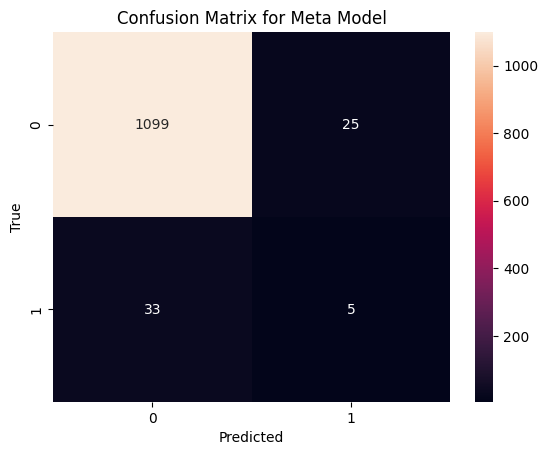

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Example for the meta model
cm = confusion_matrix(y_val, meta_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Meta Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()